In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

In [2]:
def plot_confusion_matrix(cm, classes, title):
    # Calculate accuracy
    accuracy = np.trace(cm) / np.sum(cm)  # np.trace() returns the sum of diagonal elements
    
    # Plot the confusion matrix
    plt.figure(figsize=(3, 3))  # Set figure size similar to CNN plot
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Use Blues colormap
    plt.title(title)
    
    tick_marks = np.arange(len(classes))  # Generate tick positions for each class
    plt.xticks(tick_marks, classes, rotation=45)  # Rotate x-axis labels
    plt.yticks(tick_marks, classes)  # Set y-axis labels
    
    # Display values inside the matrix
    for i in range(len(classes)):  
        for j in range(len(classes)):  
            plt.text(j, i, cm[i, j], horizontalalignment="center", 
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()  # Adjust layout
    plt.show()

    return accuracy  # Return the accuracy

def accuracy_per_class(y_true, y_pred, classes):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy for each class
    for i, class_name in enumerate(classes):
        correct_class = cm[i, i]  # Diagonal elements are correct predictions
        total_class = np.sum(cm[i, :])  # Sum of elements in the row gives total samples of that class
        accuracy = correct_class / total_class if total_class > 0 else 0
        print(f'Accuracy for class "{class_name}": {accuracy * 100:.2f}%')

### Importing and Preprocessing of data

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images
    transforms.ToTensor(),  # Convert to tensor
])

# Loading the dataset using ImageFolder
dataset_path = '/home/laura/Desktop/OsloUni/ML/Project3/archive/'
dataset = datasets.ImageFolder(dataset_path, transform=transform)
# The ImageFolder class assumes the dataset is organized into subfolders representing class labels.
# The `transform` argument ensures that all images undergo the specified transformations.

# Split data
train_size = int(0.7 * len(dataset))  # 70% of the dataset for training
val_size = int(0.15 * len(dataset))   # 15% of the dataset for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders for each set
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)  # Shuffle the training data for randomness
valloader = DataLoader(val_set, batch_size=32, shuffle=False)     # No shuffling for validation
testloader = DataLoader(test_set, batch_size=32, shuffle=False)   # No shuffling for testing

# converts the DataLoader objects to NumPy arrays, which are more suitable for scikit-learn models such as logistic regression
def dataloader_to_numpy(dataloader):
    data_list = []
    label_list = []
    for images, labels in dataloader:
        images = images.view(images.size(0), -1).numpy()  # Flatten images
        # This flattens each image into a 1D vector. 
        # The images are initially in the shape (batch_size, 3, 128, 128) (batch size, channels, height, width). 
        # After flattening, the shape becomes (batch_size, 3 * 128 * 128)
        data_list.append(images)
        label_list.append(labels.numpy())
    return np.vstack(data_list), np.hstack(label_list)

X_train, y_train = dataloader_to_numpy(trainloader)
X_val, y_val = dataloader_to_numpy(valloader)
X_test, y_test = dataloader_to_numpy(testloader)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [4]:
# Sizes of training, validation, and test sets
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (2307, 49152)
Validation set size: (494, 49152)
Test set size: (496, 49152)


### LOGISTIC REGRESSION

### lbfgs 1000 iterations

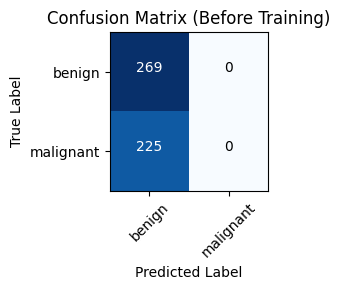

Accuracy before training on validation set:  0.5445344129554656


In [8]:
# Model initialization
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

Train Accuracy: 100.00%
Validation Accuracy: 74.49%
Test Accuracy: 74.40%


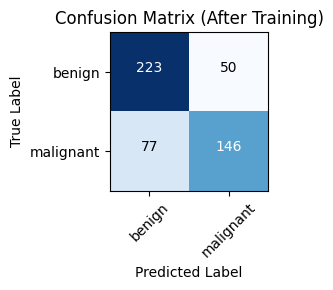

In [13]:
### TRAINING ###
logreg.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

In [12]:
# After training, evaluate on the validation set
y_pred_val = logreg.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)


Validation Accuracy per Class:
Accuracy for class "benign": 80.30%
Accuracy for class "malignant": 67.56%

Test Accuracy per Class:
Accuracy for class "benign": 81.68%
Accuracy for class "malignant": 65.47%


### Saga solver 1000 iterations

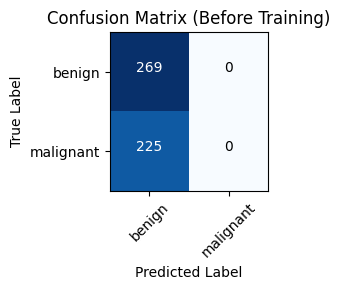

Accuracy before training on validation set:  0.5445344129554656


/home/laura/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train Accuracy: 97.36%
Validation Accuracy: 77.33%
Test Accuracy: 76.61%


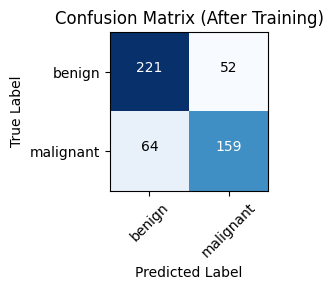


Validation Accuracy per Class:
Accuracy for class "benign": 80.67%
Accuracy for class "malignant": 73.33%

Test Accuracy per Class:
Accuracy for class "benign": 80.95%
Accuracy for class "malignant": 71.30%


In [16]:
# Model initialization
logreg_saga_no_penalty = LogisticRegression(max_iter=1000, random_state=42, solver='saga', penalty=None)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

### TRAINING ###
logreg_saga_no_penalty.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg_saga_no_penalty.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg_saga_no_penalty.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg_saga_no_penalty.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg_saga_no_penalty.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

# After training, evaluate on the validation set
y_pred_val = logreg_saga_no_penalty.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg_saga_no_penalty.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)

### sag sover (Stochastic Average Gradient) 1000 iterations

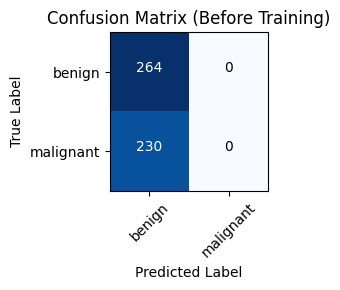

Accuracy before training on validation set:  0.5344129554655871
Train Accuracy: 99.05%
Validation Accuracy: 77.13%
Test Accuracy: 75.20%


/home/laura/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


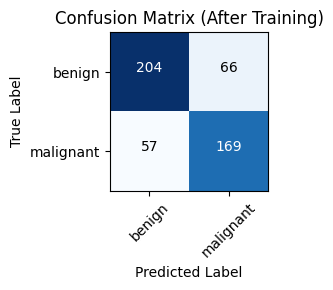


Validation Accuracy per Class:
Accuracy for class "benign": 80.68%
Accuracy for class "malignant": 73.04%

Test Accuracy per Class:
Accuracy for class "benign": 75.56%
Accuracy for class "malignant": 74.78%


In [7]:
# Model initialization
logreg_sag_no_penalty = LogisticRegression(max_iter=1000, random_state=42, solver='sag', penalty=None)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

### TRAINING ###
logreg_sag_no_penalty.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg_sag_no_penalty.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg_sag_no_penalty.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg_sag_no_penalty.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg_sag_no_penalty.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

# After training, evaluate on the validation set
y_pred_val = logreg_sag_no_penalty.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg_sag_no_penalty.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)

### newton-cg 1000 iterations

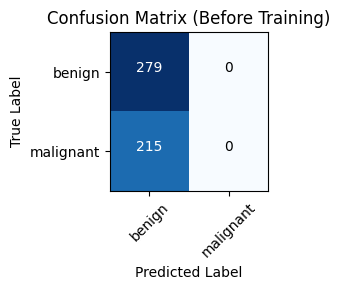

Accuracy before training on validation set:  0.5647773279352226
Train Accuracy: 100.00%
Validation Accuracy: 75.30%
Test Accuracy: 77.22%


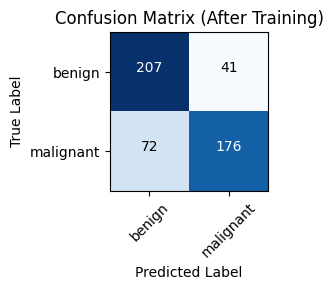


Validation Accuracy per Class:
Accuracy for class "benign": 82.44%
Accuracy for class "malignant": 66.05%

Test Accuracy per Class:
Accuracy for class "benign": 83.47%
Accuracy for class "malignant": 70.97%


In [5]:
# Model initialization
logreg_newton_1000 = LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg', penalty=None)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

### TRAINING ###
logreg_newton_1000.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg_newton_1000.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg_newton_1000.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg_newton_1000.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg_newton_1000.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

# After training, evaluate on the validation set
y_pred_val = logreg_newton_1000.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg_newton_1000.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)

### lbfgs 5000 iterations

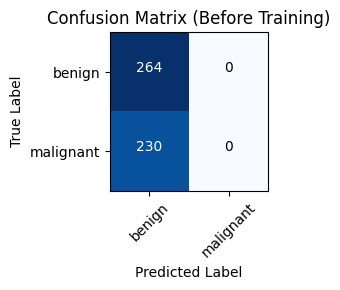

Accuracy before training on validation set:  0.5344129554655871
Train Accuracy: 100.00%
Validation Accuracy: 76.11%
Test Accuracy: 73.59%


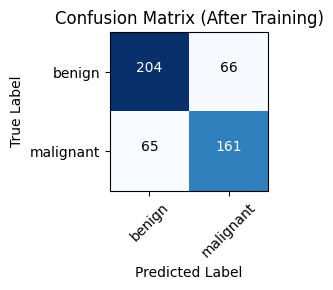


Validation Accuracy per Class:
Accuracy for class "benign": 81.06%
Accuracy for class "malignant": 70.43%

Test Accuracy per Class:
Accuracy for class "benign": 75.56%
Accuracy for class "malignant": 71.24%


In [5]:
# Model initialization
logreg_saga_no_penalty = LogisticRegression(max_iter=5000, random_state=42)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

### TRAINING ###
logreg_saga_no_penalty.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg_saga_no_penalty.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg_saga_no_penalty.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg_saga_no_penalty.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg_saga_no_penalty.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

# After training, evaluate on the validation set
y_pred_val = logreg_saga_no_penalty.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg_saga_no_penalty.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)

### Saga 5000 iterations

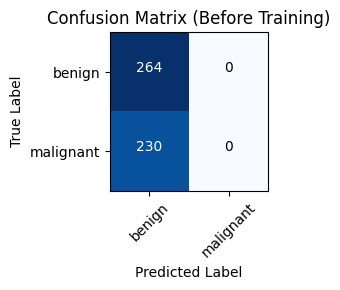

Accuracy before training on validation set:  0.5344129554655871
Train Accuracy: 99.96%
Validation Accuracy: 76.52%
Test Accuracy: 75.40%


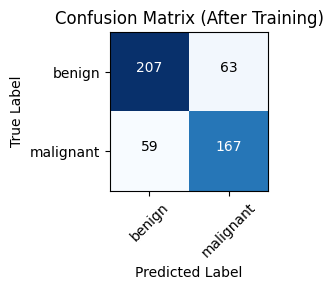


Validation Accuracy per Class:
Accuracy for class "benign": 80.68%
Accuracy for class "malignant": 71.74%

Test Accuracy per Class:
Accuracy for class "benign": 76.67%
Accuracy for class "malignant": 73.89%


In [6]:
# Model initialization
logreg_saga_no_penalty = LogisticRegression(max_iter=5000, random_state=42, solver='saga', penalty=None)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

### TRAINING ###
logreg_saga_no_penalty.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg_saga_no_penalty.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg_saga_no_penalty.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg_saga_no_penalty.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg_saga_no_penalty.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

# After training, evaluate on the validation set
y_pred_val = logreg_saga_no_penalty.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg_saga_no_penalty.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)

### sag 5000 iterations

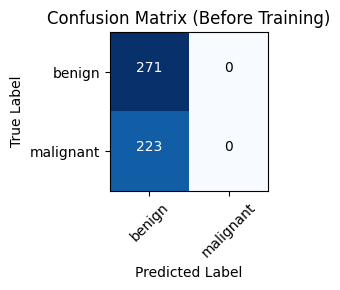

Accuracy before training on validation set:  0.548582995951417
Train Accuracy: 99.96%
Validation Accuracy: 76.11%
Test Accuracy: 77.82%


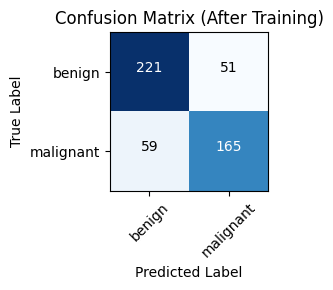


Validation Accuracy per Class:
Accuracy for class "benign": 83.76%
Accuracy for class "malignant": 66.82%

Test Accuracy per Class:
Accuracy for class "benign": 81.25%
Accuracy for class "malignant": 73.66%


In [5]:
# Model initialization
logreg_sag_no_penalty = LogisticRegression(max_iter=5000, random_state=42, solver='sag', penalty=None)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

### TRAINING ###
logreg_sag_no_penalty.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg_sag_no_penalty.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg_sag_no_penalty.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg_sag_no_penalty.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg_sag_no_penalty.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

# After training, evaluate on the validation set
y_pred_val = logreg_sag_no_penalty.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg_sag_no_penalty.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)

### newton-cg 5000 iterations

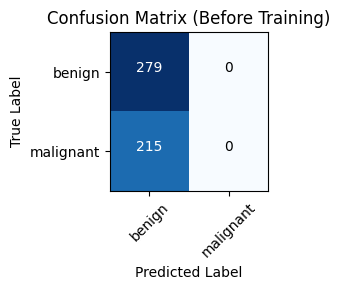

Accuracy before training on validation set:  0.5647773279352226
Train Accuracy: 100.00%
Validation Accuracy: 75.30%
Test Accuracy: 77.22%


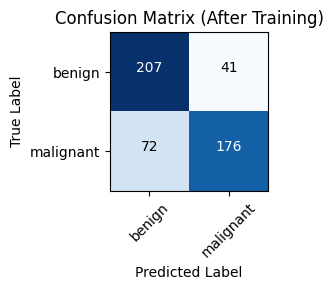


Validation Accuracy per Class:
Accuracy for class "benign": 82.44%
Accuracy for class "malignant": 66.05%

Test Accuracy per Class:
Accuracy for class "benign": 83.47%
Accuracy for class "malignant": 70.97%


In [7]:
# Model initialization
logreg_newton_5000 = LogisticRegression(max_iter=5000, random_state=42, solver='newton-cg', penalty=None)

# Confusion matrix
y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
cm_initial = confusion_matrix(y_val, y_pred_val_initial)


before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
print("Accuracy before training on validation set: ",before_accuracy)

### TRAINING ###
logreg_newton_5000.fit(X_train, y_train)

# Performance evaluation
train_accuracy = accuracy_score(y_train, logreg_newton_5000.predict(X_train))
val_accuracy = accuracy_score(y_val, logreg_newton_5000.predict(X_val))
test_accuracy = accuracy_score(y_test, logreg_newton_5000.predict(X_test))

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_test = logreg_newton_5000.predict(X_test)
cm_after = confusion_matrix(y_test, y_pred_test)

after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")

# After training, evaluate on the validation set
y_pred_val = logreg_newton_5000.predict(X_val)
print("\nValidation Accuracy per Class:")
accuracy_per_class(y_val, y_pred_val, dataset.classes)

# After training, evaluate on the test set
y_pred_test = logreg_newton_5000.predict(X_test)
print("\nTest Accuracy per Class:")
accuracy_per_class(y_test, y_pred_test, dataset.classes)

## Ridge Regularization

### Ridge saga 5000 iterations

In [6]:
Cs = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]
for c in Cs:
    print("\n\nRegularization coefficient: ", c)
    # Model initialization
    logreg_Ridge_penalty = LogisticRegression(max_iter=5000, random_state=42, solver='saga',penalty='l2', C=c)
    
    # Confusion matrix
    y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
    #cm_initial = confusion_matrix(y_val, y_pred_val_initial)
    
    
    #before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
    #print("Accuracy before training on validation set: ",before_accuracy)
    
    ### TRAINING ###
    logreg_Ridge_penalty.fit(X_train, y_train)
    
    # Performance evaluation
    train_accuracy = accuracy_score(y_train, logreg_Ridge_penalty.predict(X_train))
    val_accuracy = accuracy_score(y_val, logreg_Ridge_penalty.predict(X_val))
    test_accuracy = accuracy_score(y_test, logreg_Ridge_penalty.predict(X_test))
    
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    y_pred_test = logreg_Ridge_penalty.predict(X_test)
    cm_after = confusion_matrix(y_test, y_pred_test)
    
    #after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")
    
    # After training, evaluate on the validation set
    y_pred_val = logreg_Ridge_penalty.predict(X_val)
    print("\nValidation Accuracy per Class:")
    accuracy_per_class(y_val, y_pred_val, dataset.classes)
    
    # After training, evaluate on the test set
    y_pred_test = logreg_Ridge_penalty.predict(X_test)
    print("\nTest Accuracy per Class:")
    accuracy_per_class(y_test, y_pred_test, dataset.classes)



Regularization coefficient:  1e-08
Train Accuracy: 62.33%
Validation Accuracy: 61.54%
Test Accuracy: 59.68%

Validation Accuracy per Class:
Accuracy for class "benign": 95.96%
Accuracy for class "malignant": 19.37%

Test Accuracy per Class:
Accuracy for class "benign": 96.21%
Accuracy for class "malignant": 18.10%


Regularization coefficient:  1e-07
Train Accuracy: 74.56%
Validation Accuracy: 70.45%
Test Accuracy: 70.77%

Validation Accuracy per Class:
Accuracy for class "benign": 72.43%
Accuracy for class "malignant": 68.02%

Test Accuracy per Class:
Accuracy for class "benign": 75.76%
Accuracy for class "malignant": 65.09%


Regularization coefficient:  1e-06
Train Accuracy: 78.07%
Validation Accuracy: 73.28%
Test Accuracy: 76.41%

Validation Accuracy per Class:
Accuracy for class "benign": 71.69%
Accuracy for class "malignant": 75.23%

Test Accuracy per Class:
Accuracy for class "benign": 75.00%
Accuracy for class "malignant": 78.02%


Regularization coefficient:  1e-05
Train Acc

## lbfgs solver 1000 iterations

In [7]:
Cs = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]
for c in Cs:
    print("/n/nRegularization coefficient: ", c)
    # Model initialization
    logreg_Ridge_penalty = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=c)
    
    # Confusion matrix
    y_pred_val_initial = np.zeros_like(y_val)  # Random initial predictions (all zeros)
    #cm_initial = confusion_matrix(y_val, y_pred_val_initial)
    
    
    #before_accuracy = plot_confusion_matrix(cm_initial, dataset.classes, "Confusion Matrix (Before Training)")
    #print("Accuracy before training on validation set: ",before_accuracy)
    
    ### TRAINING ###
    logreg_Ridge_penalty.fit(X_train, y_train)
    
    # Performance evaluation
    train_accuracy = accuracy_score(y_train, logreg_Ridge_penalty.predict(X_train))
    val_accuracy = accuracy_score(y_val, logreg_Ridge_penalty.predict(X_val))
    test_accuracy = accuracy_score(y_test, logreg_Ridge_penalty.predict(X_test))
    
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    y_pred_test = logreg_Ridge_penalty.predict(X_test)
    cm_after = confusion_matrix(y_test, y_pred_test)
    
    #after_accuracy = plot_confusion_matrix(cm_after, dataset.classes, "Confusion Matrix (After Training)")
    
    # After training, evaluate on the validation set
    y_pred_val = logreg_Ridge_penalty.predict(X_val)
    print("\nValidation Accuracy per Class:")
    accuracy_per_class(y_val, y_pred_val, dataset.classes)
    
    # After training, evaluate on the test set
    y_pred_test = logreg_Ridge_penalty.predict(X_test)
    print("\nTest Accuracy per Class:")
    accuracy_per_class(y_test, y_pred_test, dataset.classes)

Regularization coefficient:  0.0001
Train Accuracy: 82.92%
Validation Accuracy: 80.57%
Test Accuracy: 79.03%

Validation Accuracy per Class:
Accuracy for class "benign": 79.85%
Accuracy for class "malignant": 81.42%

Test Accuracy per Class:
Accuracy for class "benign": 81.01%
Accuracy for class "malignant": 76.89%
Regularization coefficient:  0.001
Train Accuracy: 91.20%
Validation Accuracy: 80.16%
Test Accuracy: 79.64%

Validation Accuracy per Class:
Accuracy for class "benign": 82.09%
Accuracy for class "malignant": 77.88%

Test Accuracy per Class:
Accuracy for class "benign": 81.78%
Accuracy for class "malignant": 77.31%
Regularization coefficient:  0.01
Train Accuracy: 99.39%
Validation Accuracy: 78.34%
Test Accuracy: 79.23%

Validation Accuracy per Class:
Accuracy for class "benign": 82.46%
Accuracy for class "malignant": 73.45%

Test Accuracy per Class:
Accuracy for class "benign": 83.72%
Accuracy for class "malignant": 74.37%
Regularization coefficient:  0.1
Train Accuracy: 100